Kullanılacak Cihaz: cuda
En iyi modelin ağırlıkları başarıyla yüklendi.
Sınıf etiketleri yüklendi.
Test resimleri üzerinde tahminler yapılıyor...


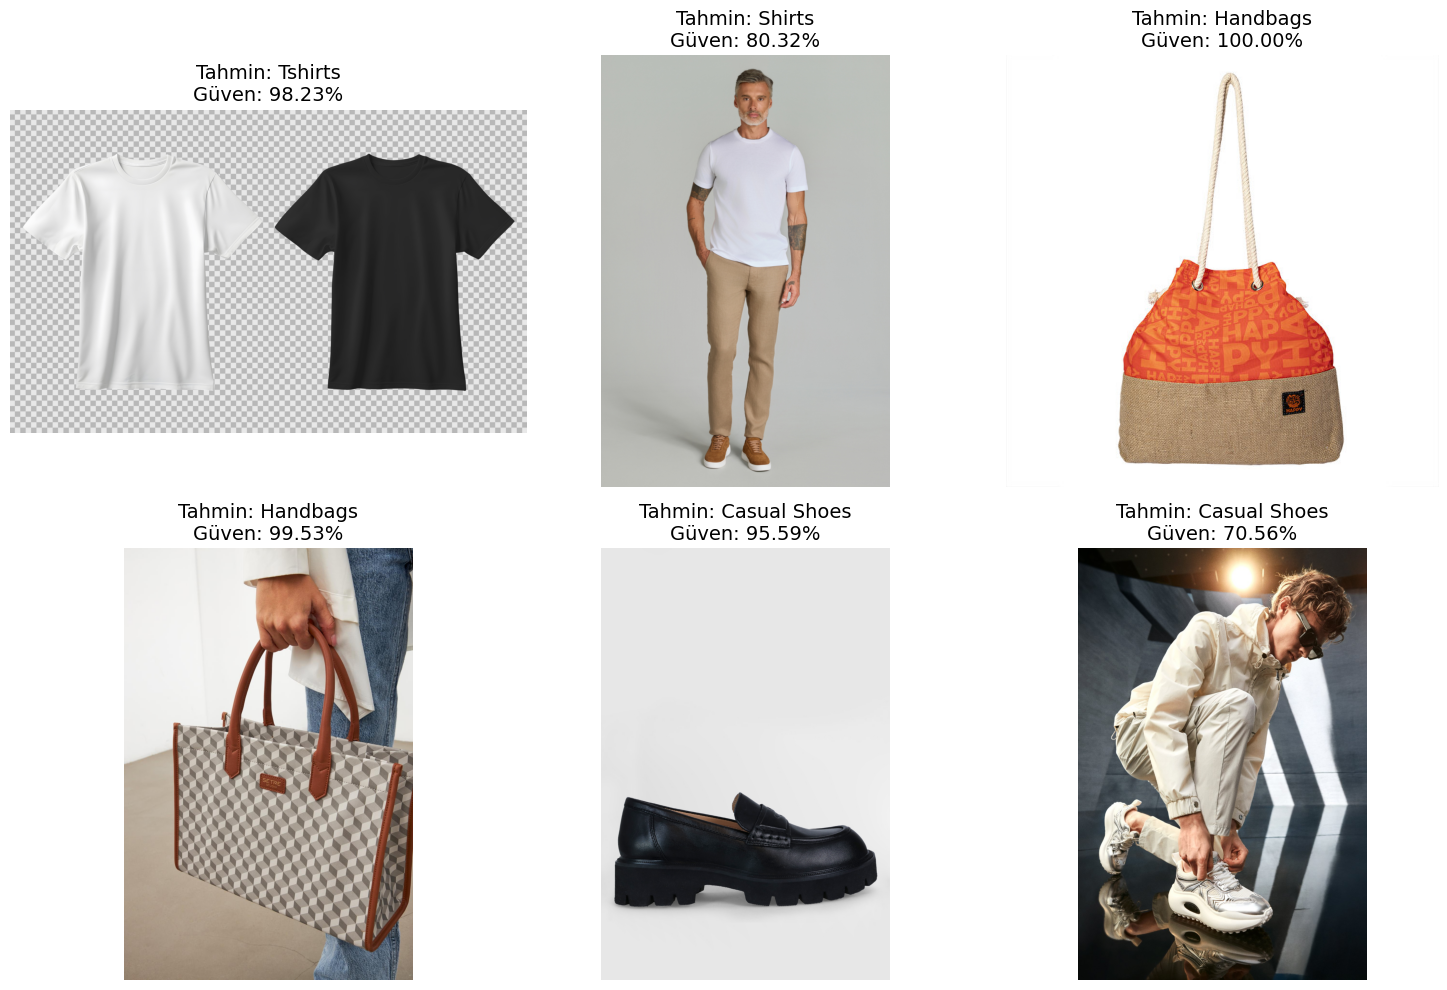

In [2]:
# ==============================================================================
# AURA AI ENGINE - ADIM 5: MODELİ TEST ETME (INFERENCE) - SON VERSİYON
# ==============================================================================
# AMAÇ: Eğittiğimiz en iyi modeli yükleyerek, BİLGİSAYARIMIZDAKİ yerel görseller
#       üzerinde tahminler yaptırmak.
# ------------------------------------------------------------------------------

# --- ADIM 1: Gerekli Kütüphanelerin Yüklenmesi ve Yapılandırma ---

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

# -- Ayarlar ve Yollar --
NUM_CLASSES = 10
PROCESSED_DATA_PATH = os.path.join("..", "data", "processed")
MODEL_PATH = os.path.join("..", "models", "best_model.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılacak Cihaz: {device}")


# --- ADIM 2: Model Mimarisi ve Sınıf Etiketlerinin Yüklenmesi ---

model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()
print("En iyi modelin ağırlıkları başarıyla yüklendi.")

train_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "train_cleaned.csv"))
classes = sorted(train_df['articleType'].unique())
idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}
print("Sınıf etiketleri yüklendi.")


# --- ADIM 3: TAHMİN FONKSİYONU (YEREL DOSYA İÇİN DÜZELTİLDİ) ---

# Fonksiyonu, URL yerine yerel dosya yolu alacak şekilde güncelledim.
def predict_local_image(image_path, model, device, idx_to_class):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    try:
        # Resmi artık internetten değil, doğrudan yerel yoldan açıyoruz.
        img = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Hata: '{image_path}' bulunamadı. Dosya adını ve yolunu kontrol edin.")
        return None, None, None

    img_tensor = transform(img)
    batch_tensor = torch.unsqueeze(img_tensor, 0).to(device)
    
    with torch.no_grad():
        output = model(batch_tensor)
    
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    prediction_idx = output.argmax().item()
    prediction_class = idx_to_class[prediction_idx]
    confidence_score = probabilities[prediction_idx].item() * 100
    
    return img, prediction_class, confidence_score


# --- ADIM 4: YEREL RESİMLERLE MODELİ TEST ETME (DOSYA YOLU DÜZELTİLDİ) ---

# Not defteri 'notebooks' klasöründe çalıştığı için, bir üst dizine çıkıp
# 'test_images' klasörüne girmesi için yolların başına '../' ekliyoruz.
test_image_files = [
    "../test_images/urun_tshirt.jpg",
    "../test_images/insan_tshirt.jpg",
    "../test_images/canta.jpg",
    "../test_images/insan_canta.jpg",
    "../test_images/urun_ayakkabi.jpg",
    "../test_images/insan_ayakkabi.jpg"
]

plt.figure(figsize=(15, 10))
print("Test resimleri üzerinde tahminler yapılıyor...")

for i, file_path in enumerate(test_image_files):
    img, pred_class, confidence = predict_local_image(file_path, model, device, idx_to_class)
    
    if img:
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        title_text = f"Tahmin: {pred_class}\nGüven: {confidence:.2f}%"
        actual_filename = os.path.basename(file_path)
        plt.xlabel(actual_filename, fontsize=10)
        plt.title(title_text, fontsize=14)
        plt.axis('off')

plt.tight_layout()
plt.show()